## I searched online for an interesting music dataset and found one on [Kaggle](https://www.kaggle.com/purumalgi/music-genre-classification). The data includes musical features as well as a genre.

## This data was used for a competition in which participants were asked to upload the genres for a different set of songs. The results were never revealed. I will also be making a genre prediction model but will split the data into a train/test set instead of using the competition set of songs.

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('fivethirtyeight')

import pandas as pd
import seaborn as sns

# 1. Data Loading

### Upon loading the data, I realized the genre label consists of numbers. I converted them to the appropriate genre name in order to better understand the data. I also removed the 'mode' feature as it is not clear what it refers to.

In [3]:
# read data
data = pd.read_csv('train.csv')
# read in genre mapping file
genre_mapping = pd.read_csv('genre-mapping.csv', index_col = 'ID').to_dict()['Genre']
# map genre and add to the data
data['Genre'] = data['Class'].apply(lambda x: genre_mapping[x]).astype('category')

# delete Class column - replaced by Genre column
del data['Class']
# delete mode column - no documentation on what the feature means
del data['mode']

In [4]:
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Genre
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,HipHop
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,Rock
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,Indie Alt
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,HipHop
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,Rock


### They key and time signature are represented as numbers but are not ordinal. I converted them to a 'category' type so that Pandas will not treat it as a number.

In [5]:
## convert key and time signature to a category so that are not considered ordinal
data['key'] = data['key'].astype('category')
data['time_signature'] = data['time_signature'].astype('category')

In [6]:
data.dtypes

Artist Name             object
Track Name              object
Popularity             float64
danceability           float64
energy                 float64
key                   category
loudness               float64
speechiness            float64
acousticness           float64
instrumentalness       float64
liveness               float64
valence                float64
tempo                  float64
duration_in min/ms     float64
time_signature        category
Genre                 category
dtype: object

### Below is what each of the fields represent

1. Artist Name - name of the artist

2. Track Name - name of the song

3. Popularity - how popular the song is

4. danceability - how well a song is suited for dancing

5. energy - a measure of intensity and activity in the song

6. key - the musical key the song is in

7. loudness - the average decibels of the song

8. speechiness - the presence of spoken word in the song

9. acousticness - how acoustic the song is

10. instrumentalness - how much of the song consists of instrumentals

11. liveness - the probability of a song being recorded with a live audience

12. valence - the amount of positivity in the song

13. tempo - the speed of the song

14. duration_in min/ms - the length of the song

15. time_signature - the time signature of the song based on quarter notes

16. Genre - the genre of the song


##### some definitions come from [Spotify](https://developer.spotify.com/discover/)

### I only use the continuous variables as the features in my model

In [7]:
# get list of genres
genres = data['Genre'].unique().tolist()

# get list of features - only consider float coluumns as features
features = data.select_dtypes(include=['float64']).columns.tolist()

# 2. Data Cleaning

## 2.1 Summaries

### I first look at the distribution and some basic statistics of the features to find anomolies.

/Users/krishna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


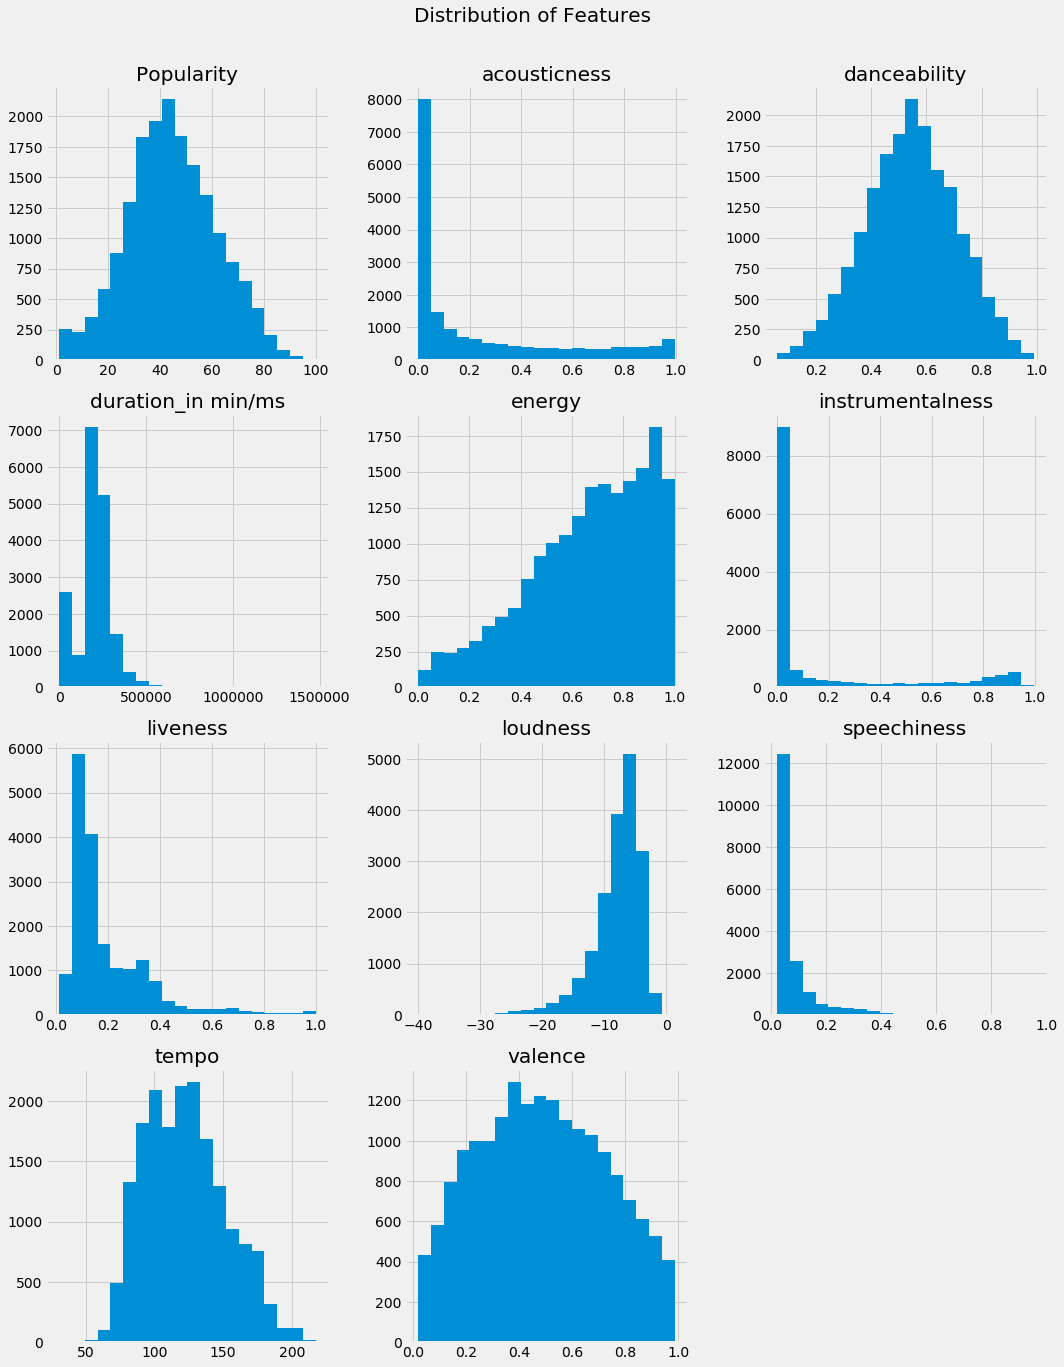

In [8]:
fig,ax = plt.subplots(figsize = (15,20))

# plot histogram of all features with floats
data[features].hist(ax = ax, bins = 20);

# add title
fig.suptitle('Distribution of Features', fontsize = 20);
# reposition title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [9]:
# output basic stats for each feature

data[features].agg(['min','mean','median','max'])

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
min,1.000000,0.059600,0.000020,-39.95200,0.022500,0.000000,0.000001,0.01190,0.018300,30.557000,5.016500e-01
mean,44.512124,0.543433,0.662777,-7.91066,0.079707,0.247082,0.177562,0.19617,0.486208,122.623294,2.007445e+05
median,44.000000,0.545000,0.700000,-7.01600,0.047400,0.081400,0.003910,0.12900,0.481000,120.065500,2.091600e+05
max,100.000000,0.989000,1.000000,1.35500,0.955000,0.996000,0.996000,1.00000,0.986000,217.416000,1.477187e+06


## 2.2 Fix Duration Column

### The duration column minimum and maximum is 7 orders of magnitude. This and the duration feature name indicates that some lenghts are in milliseconds while some are in minutes.

### The log-log histogram below indicates a clear separation between the songs that are in ms vs minutes.

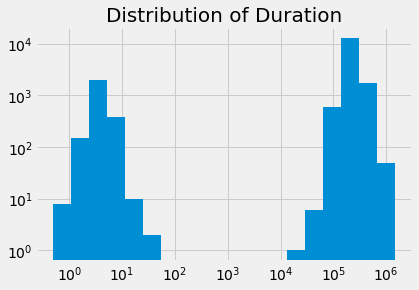

In [10]:
# get duration column
x = data['duration_in min/ms']

# make 20 logbins from the minimum to the maximum duration
logbins = np.geomspace(x.min(), x.max(), 20)

# plot bins on a logscale in order to make the bins look equal width
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of Duration', fontsize = 20);

### To double check, I show the frequency of values in the binned data. There are a middle section of bins with no values that can be used as the limit to differentiate songs in millisecond vs minutes. 

In [11]:
# find some boundaries on where there is data

pd.DataFrame(pd.cut(data['duration_in min/ms'], logbins)).groupby('duration_in min/ms').size()

duration_in min/ms
(0.502, 1.099]                  7
(1.099, 2.406]                149
(2.406, 5.27]                2034
(5.27, 11.543]                377
(11.543, 25.28]                10
(25.28, 55.367]                 2
(55.367, 121.263]               0
(121.263, 265.586]              0
(265.586, 581.675]              0
(581.675, 1273.96]              0
(1273.96, 2790.175]             0
(2790.175, 6110.924]            0
(6110.924, 13383.892]           0
(13383.892, 29312.843]          1
(29312.843, 64199.766]          6
(64199.766, 140607.651]       609
(140607.651, 307953.015]    13012
(307953.015, 674465.855]     1738
(674465.855, 1477187.0]        49
dtype: int64

In [12]:
## double check that we are capturing all of the data with the boundaries

# create upper and lower bound
f1 = data['duration_in min/ms'] <= 55.367
f2 = data['duration_in min/ms'] >= 13383.892

# print shape of data to see if it matches the original dataset
data[f1 | f2].shape == data.shape

True

In [13]:
# for the large time values, convert to minutes
# low values are assumed to be minutes
data['Duration'] = data['duration_in min/ms'].apply(lambda x: x if x <= 55.367 else x/60000)

# delete original column
del data['duration_in min/ms']

### Once converted to minutes, the histogram makes more sense.

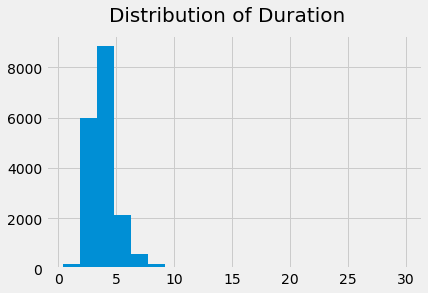

In [14]:
# plot histogram of new duration
data['Duration'].hist(bins = 20)
plt.suptitle('Distribution of Duration', fontsize = 20);

## 2.3 Missing Data

### 3 features contain missing values. Dropping these rows reduces the data size to ~65% of the original

In [15]:
# find how many missing values there are per column

print(data.dropna().shape[0]/data.shape[0])
print(data.isnull().sum())

0.6564236496999333
Artist Name            0
Track Name             0
Popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
time_signature         0
Genre                  0
Duration               0
dtype: int64


# 3. Exploratory Data Analysis


### There is a clear class imbalance with Rock having 10 times more songs than Country. This will need to be accounted for in the model.

In [16]:
# calculate the amount of data in each genre
data.groupby('Genre').size().sort_values(ascending = False)

Genre
Rock             4949
Indie Alt        2587
Pop              2524
Metal            1854
HipHop           1447
Alt_Music        1373
Blues            1272
Acoustic/Folk     625
Instrumental      576
Bollywood         402
Country           387
dtype: int64

## 3.1 Feature Distribution Across Genres

### In order to understand what the features are like across genres, I plot their distributions in mean order.

1. Expectedly, pop music has the most popular songs. More surpisingly, on average, country music is more popular.
2. Hip Hop and Pop are the most danceable music. I would also expect Bollywood music to be ranked higher; this could be due to its lack of western popularity.
3. Metal has the most energy and the most loud genre. 
4. Hip Hop is the most speech based genre while the instrumental genre contains the most amount of instruments (obviously) and the most acoustic.
5. There is no significant pattern with tempo and genre. 
6. Bollywood music tends to be the longest. I am surprised that instrumental music is not higher ranked; this could be due to an underrepresentation of classical music.

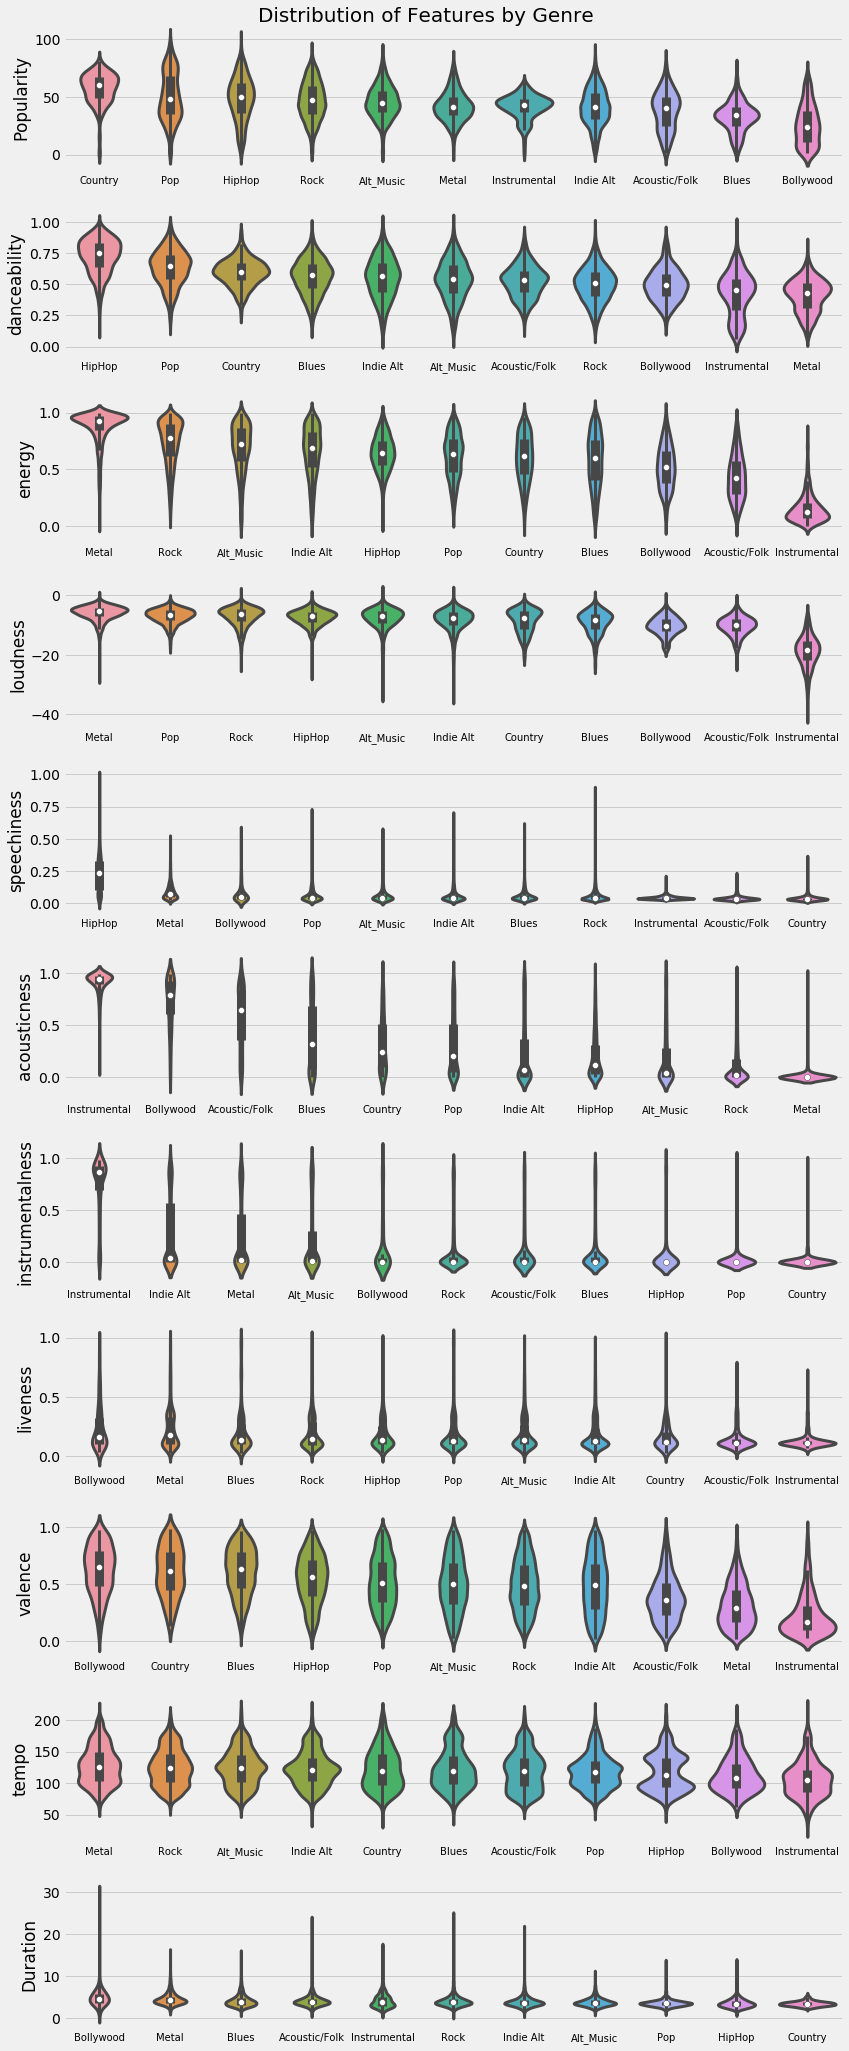

In [17]:
# configure plot
fig,axes = plt.subplots(len(features),1,figsize = (12,30))

# get list of updated features
features = data.select_dtypes(include=['float64']).columns.tolist()

# loop through all of the features
for i,feature in enumerate(features):
    
    # sort the genres by mean descending order of the features
    order = data.groupby(by=["Genre"])[feature].mean().sort_values(ascending = False).index
    # plot violin plots for each genre
    plot = sns.violinplot(x="Genre", y=feature, data=data, order = order, ax=axes[i], linewidth=3)
    # change x tick label size
    plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 10)
    # remove x label
    plot.set_xlabel('');
    
fig.suptitle('Distribution of Features by Genre', fontsize = 20);
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.savefig('Feature Distribution Across Genre.png')

# 4.  Classification

### My strategy to build a good classifier was to try many different algorithms and parameters. Because of the small amount of data and features, this is a reasonable approach.

In [18]:
# import necessary sklearn modules

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### In order to find the best model, I instantiate many options and build data structures to store all of the results

In [19]:
# build list of classifiers
classifiers = ['KNN','LogReg','SVC','RandForest','ADA','GNB']

# build dictionary of instances of each classifier
classifier_instances = {
    'KNN': KNeighborsClassifier(),
    'LogReg':LogisticRegression(multi_class = 'ovr'),
    'SVC': SVC(),
    'RandForest':RandomForestClassifier(),
    'ADA': AdaBoostClassifier(),
    'GNB': GaussianNB(),
}

# build dictionary of parameters to grid search for each classifier
parameters = {
    'KNN': {'KNN__n_neighbors':[1,5,10,15,20,25]},
    'LogReg':{'LogReg__C': [0.1 * x for x in range(1,11)]},
    'SVC': {'SVC__C':[10**-2,10**-1,10**0,10**1,10**2]},
    'RandForest':{'RandForest__max_depth':[2,4,6,8,10]},
    'ADA': {'ADA__learning_rate':[10**-2,10**-1,10**0,10**1,10**2]},
    'GNB': {},
}

# build dictionary to store trained model for each classifier
trained_models = {
    'KNN': None,
    'LogReg':None,
    'SVC': None,
    'RandForest':None,
    'ADA': None,
    'GNB': None,
}

### To build the model, I

1. separated the features and the labels
2. split the data into training and test sets
3. created a pipeline for each classifier
4. ran a gridsearch with the classifier parameters and split the training data into balanced classes
5. fit the best model for each classifier
6. saved the model

In [20]:
# create feature array
X = data[features].dropna()
# create target array
y = data.iloc[X.index]['Genre']

# split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# initialize a split to account for class imbalances
ksplits = StratifiedShuffleSplit()
# create splits
splits = list(ksplits.split(X_train,y_train))
# create an initial pipeline
pipeline_base = [('scalar',StandardScaler(with_mean=False))]

# for each classifier
for classifier in classifiers:
    print(classifier)
    
    # create an addition to the pipeline belonging to the classifier
    pipeline_addition = [(classifier,classifier_instances[classifier])]
    # create pipeline by merging the babse and then addition
    pipeline = Pipeline(pipeline_base + pipeline_addition)
    # create model with parameters from classifier
    model = GridSearchCV(estimator=pipeline, cv = splits, param_grid=parameters[classifier],verbose = 1)
    # fit model to the training data
    model.fit(X_train,y_train)
    # store trained model
    trained_models[classifier] = model
    

KNN
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogReg
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/krishna/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   42.0s finished


SVC
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandForest
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   54.1s finished


ADA
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:557: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:557: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/Users/krishna/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boo

GNB
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


# Results

## In order to analyze the models, I first calculate the training and test accuracy.

In [21]:
# import metric calculations from sklearn
from sklearn.metrics import f1_score, accuracy_score

In [22]:
# initialize dictionary to store f1 scores for each class
f1s = {classifier:None for classifier in classifiers}
# initialize dictionary to store accuracy of model on test set
accuracys = {classifier:None for classifier in classifiers}

# for each classifier
for classifier in classifiers:
    # get predicted values of the test set
    y_pred = trained_models[classifier].predict(X_test)
    # store the f1 values per label
    f1s[classifier] = f1_score(y_test, y_pred, average=None, labels = genres)  
    # store the accuracy
    accuracys[classifier] = accuracy_score(y_test, y_pred)

In [23]:
# get list of columns in the "cv_results_" that show the accuracy
score_keys = ['split{}_test_score'.format(x) for x in range(10)]
# initialize dictionary to store the scores
scores = {classifier:None for classifier in classifiers}

# iterate through the classifiers
for classifier in classifiers:
    # find the index of the accuracy values from the data splilt that produced the model
    best_index = trained_models[classifier].best_index_
    # get the summary of the trained model
    results = trained_models[classifier].cv_results_
    # store the results from the model
    scores[classifier] = [results[key][best_index] for key in score_keys]
    
# create into an appropriately shaped dataframe for visualization
scores = pd.DataFrame(scores).T

## From an initial glance, the support vector machine and the random forest model produced the highest accuracy.

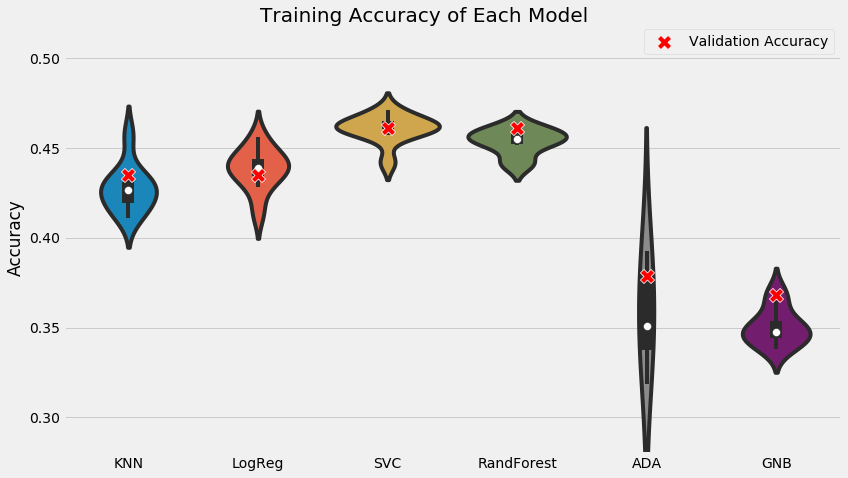

In [24]:
# initialize plo
fig,ax = plt.subplots(figsize = (12,7))

# reformat the scores to better fit the seaborn style
scores_reformat = pd.melt(scores.reset_index(), id_vars='index', value_vars=range(10))
# create a violin plot of the scores for each model
plot1 = sns.violinplot(x="index", y= 'value', data=scores_reformat, ax = ax)
plot2 = sns.scatterplot(x=list(accuracys.keys()), y= list(accuracys.values()), 
                      marker = "X", s = 200, zorder = 100, color = 'red', ax = ax, label = 'Validation Accuracy')
# remove xlabel
plot1.set_xlabel('');
# add y label
plot1.set_ylabel('Accuracy');
# change axes limits
plot1.set_ylim(0.28, 0.52);
plot1.set_xlim(-0.5,5.5);

# add title
fig.suptitle('Training Accuracy of Each Model',fontsize = 20)
# reposition title
fig.tight_layout(rect=[0, 0.03, 1, 0.98])


## I look at the F1 score to to see how well the genres were classified. Because of the many classes, the total score represents a weighted average.

### In all classifiers, the instrumental genre had the highest F1 score and thus the best precision and recall.

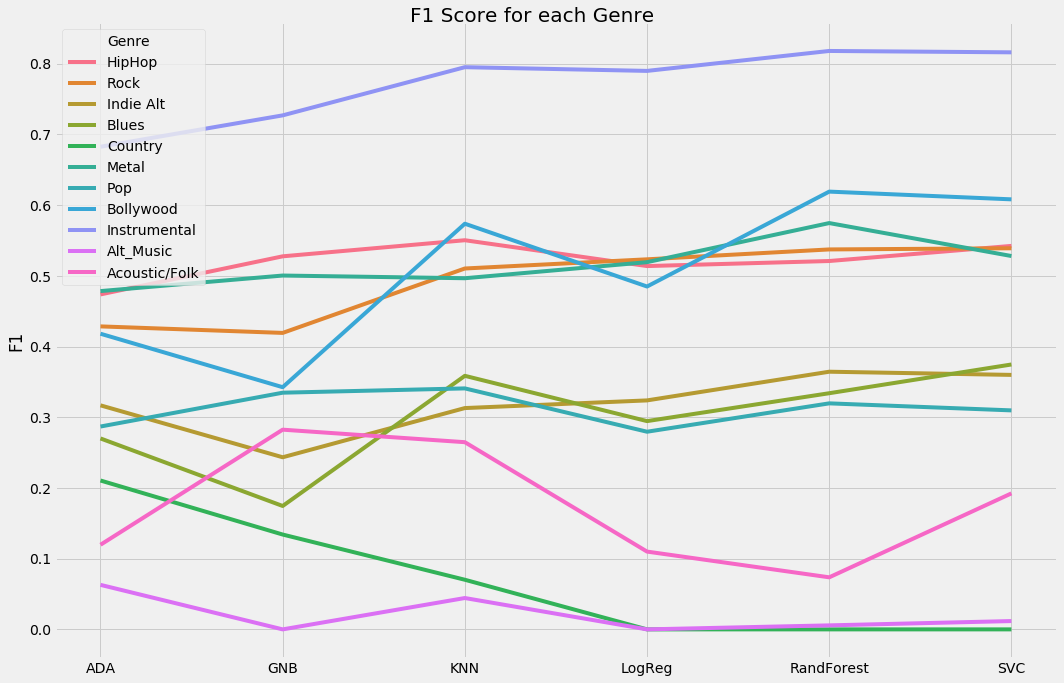

In [25]:
# create dataframe of f1s and transpose
f1sT = pd.DataFrame(f1s).T
# add genre names as column names
f1sT.columns = genres

# initialize plot
fig, ax = plt.subplots(figsize = (15,10))

# reformat the scores to better fit the seaborn style
f1s_reformat = pd.melt(f1sT.reset_index(), id_vars='index', value_vars=genres)
# rename the 'variable' column to 'Genre'
f1s_reformat.rename(columns = {"variable":"Genre"}, inplace = True)

# make line plot for each genre
ax = sns.lineplot(x="index", y= 'value', data=f1s_reformat, hue='Genre')
# reduce legend fontsize
plt.setp(ax.get_legend().get_texts(), fontsize='10') 
plt.legend(loc='upper left')
# remove x label
ax.set_xlabel('');
# add y label
ax.set_ylabel('F1');

# add title
fig.suptitle('F1 Score for each Genre',fontsize = 20)
# reposition title
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

## When looking at feature importance, energy in the SVC model was significantly more important than the other features. Acousticness was most important in the Random Forest model. 

In [26]:
from sklearn.inspection import permutation_importance

forest_permutations = permutation_importance(trained_models['RandForest'], X_test, y_test,n_jobs=-1)
forest_importances = pd.Series(forest_permutations.importances_mean, index=features)

svc_permutations = permutation_importance(trained_models['SVC'], X_test, y_test,n_jobs=-1)
svc_importances = pd.Series(svc_permutations.importances_mean, index=features)

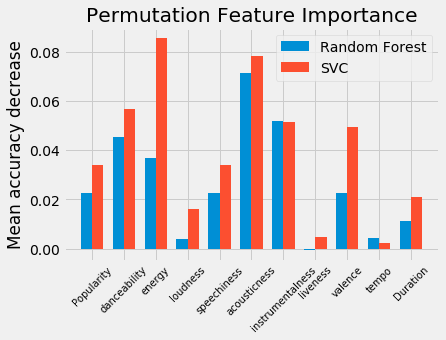

In [27]:
labels = features

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, forest_importances, width, label='Random Forest')
rects2 = ax.bar(x + width/2, svc_importances, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean accuracy decrease")
ax.set_title('Permutation Feature Importance')
ax.set_xticks(x);
ax.set_xticklabels(labels, fontsize = 10);
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
;
ax.legend()
